### EDA

In [2]:
# Importando libraries para EDA e manipulação de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Libraries para os modelos e tunagem de parâmetros no estudo
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [94]:
# Carregar a série temporal
data = pd.read_csv('Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas.csv', encoding='ISO-8859-1', sep=';', parse_dates=['Data'], index_col='Data')


In [95]:
# Converte a coluna removendo pontos e trocando a vírgula por ponto
data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'] = (
    data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)']
    .str.replace('.', '', regex=False)  # Remove os pontos
    .str.replace(',', '.', regex=False)  # Troca a vírgula por ponto
    .astype(float)                       # Converte para float
)

# Verifica a conversão
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5020 entries, 02/01/2004 to 29/12/2023
Data columns (total 1 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)  5020 non-null   float64
dtypes: float64(1)
memory usage: 78.4+ KB
None
            1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)
Data                                                                                                          
02/01/2004                                        19436701.72                                                 
05/01/2004                                        19459816.07                                                 
06/01/

In [96]:
df = data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5020 entries, 02/01/2004 to 29/12/2023
Data columns (total 1 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)  5020 non-null   float64
dtypes: float64(1)
memory usage: 78.4+ KB


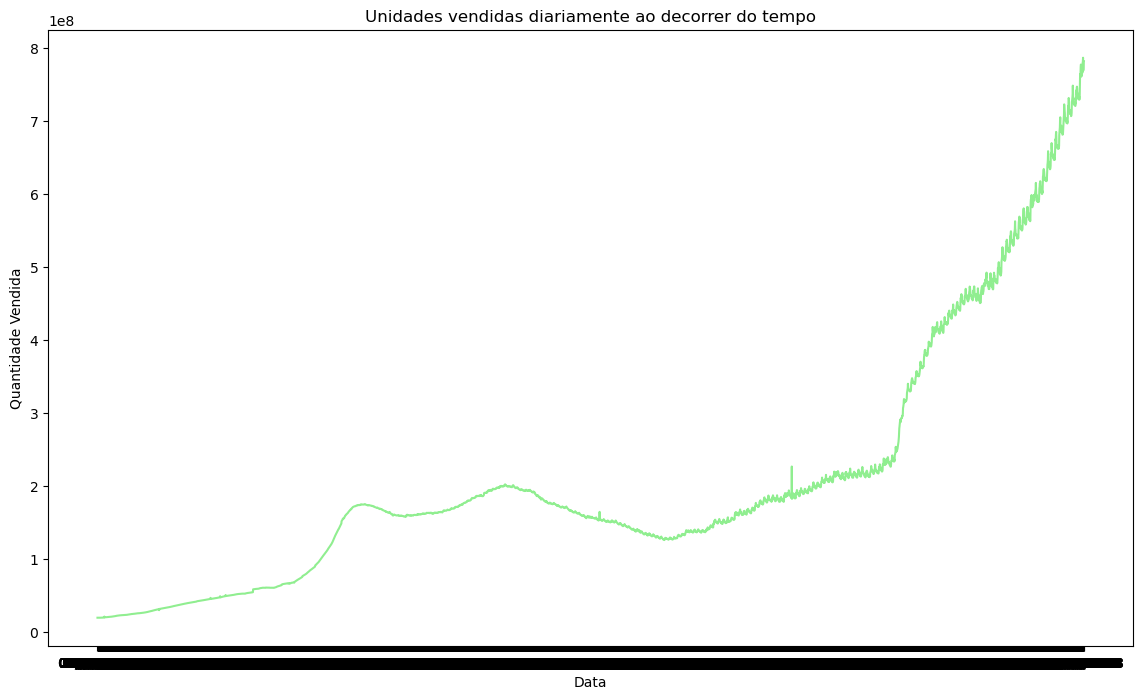

In [97]:
plt.figure(figsize=(14, 8))
plt.plot(df, label='Total Vendido por Dia', color='lightgreen')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.title('Unidades vendidas diariamente ao decorrer do tempo')

plt.show()

### Decomposição da Série

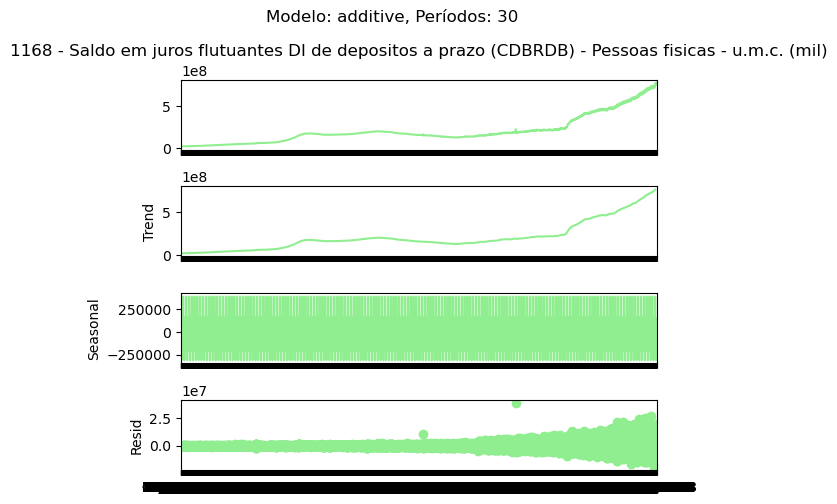

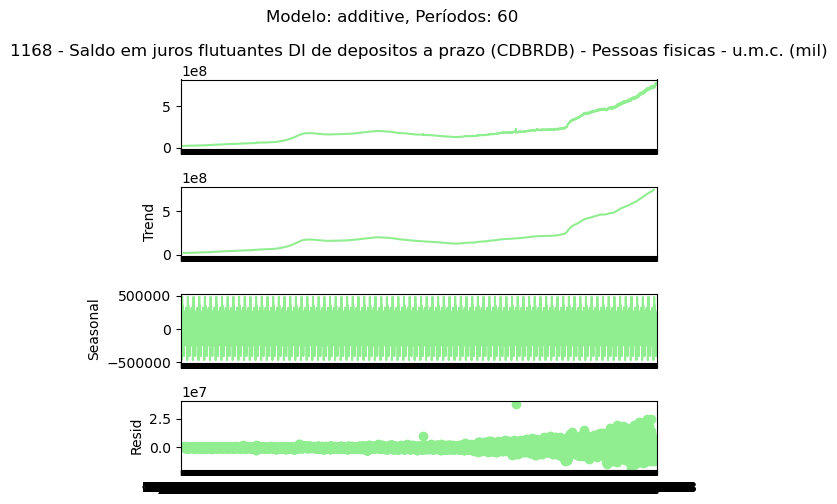

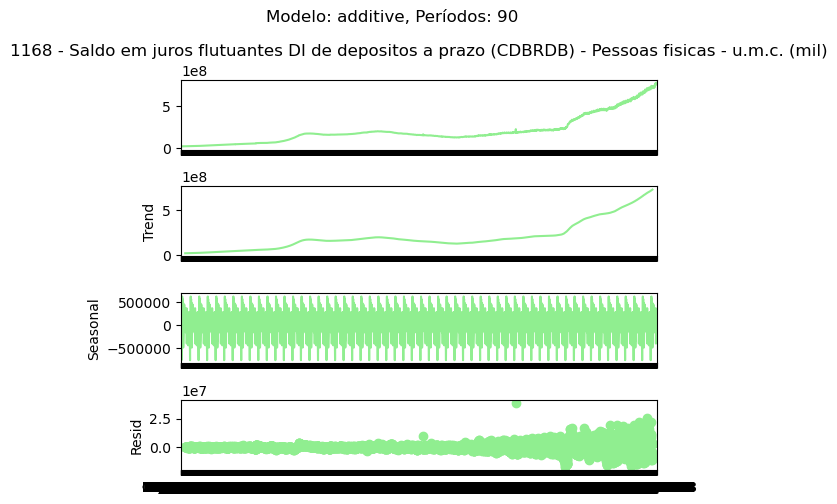

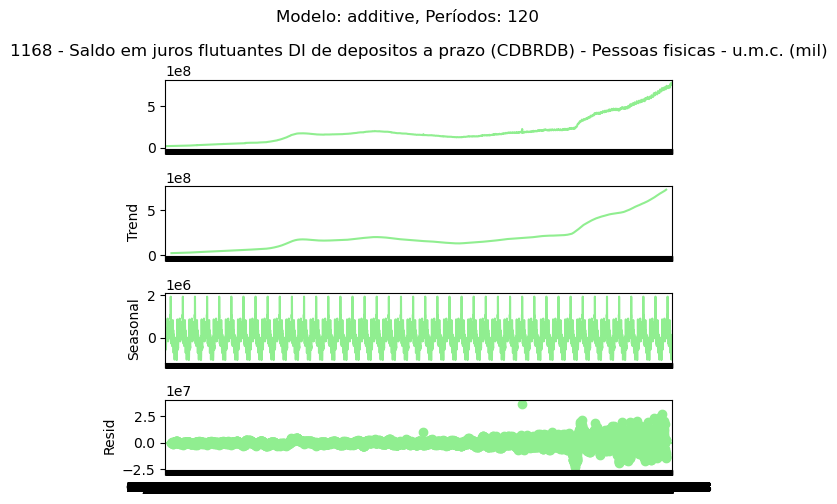

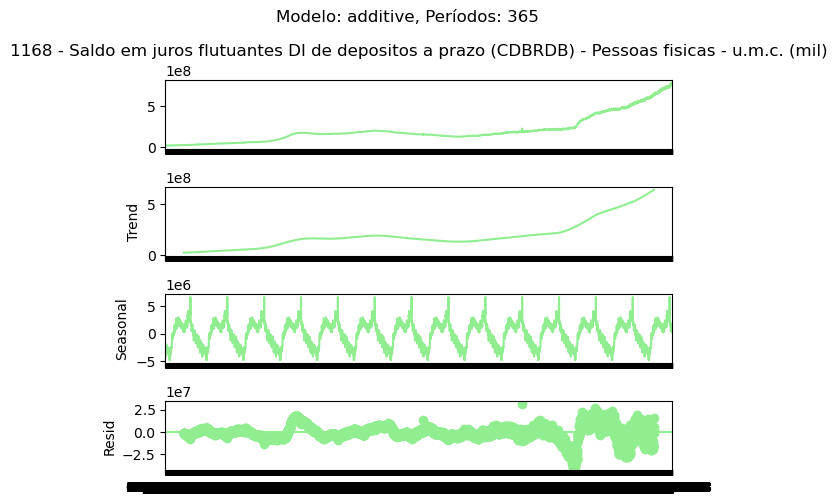

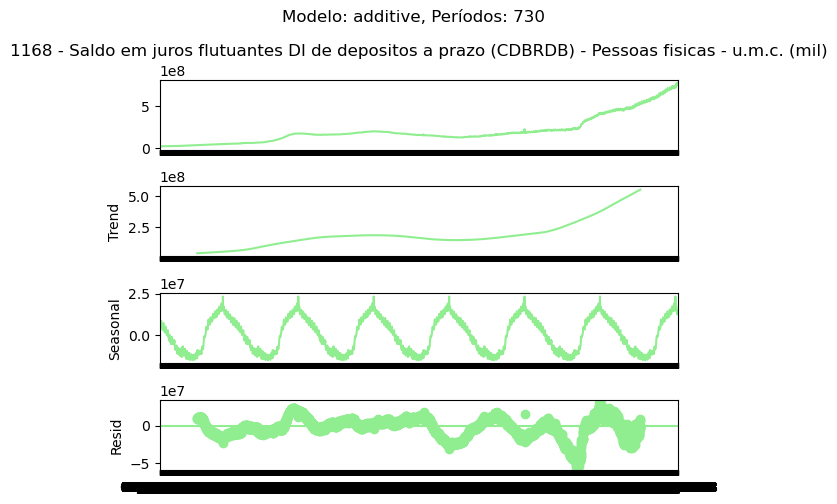

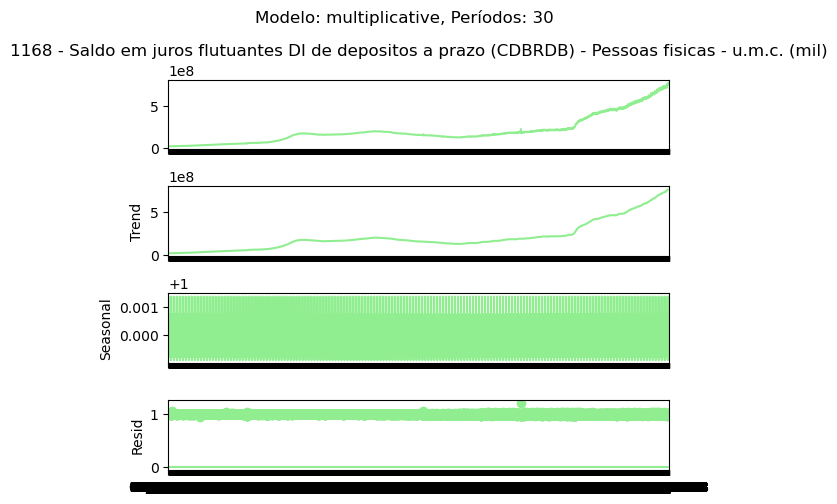

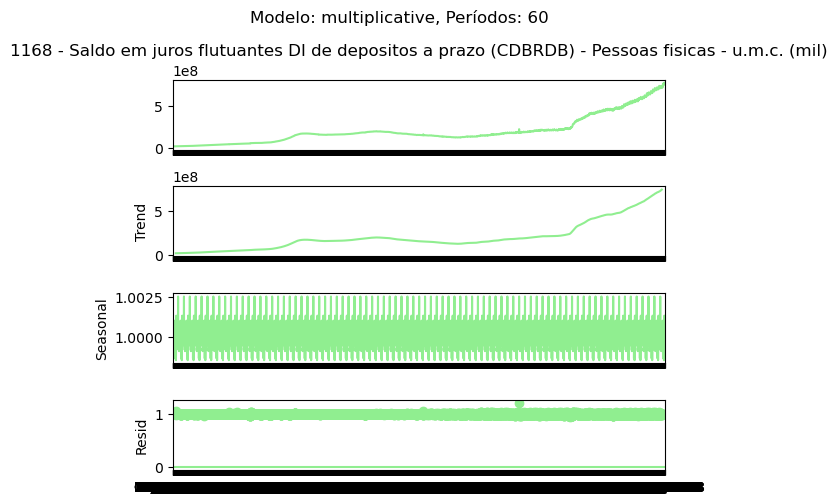

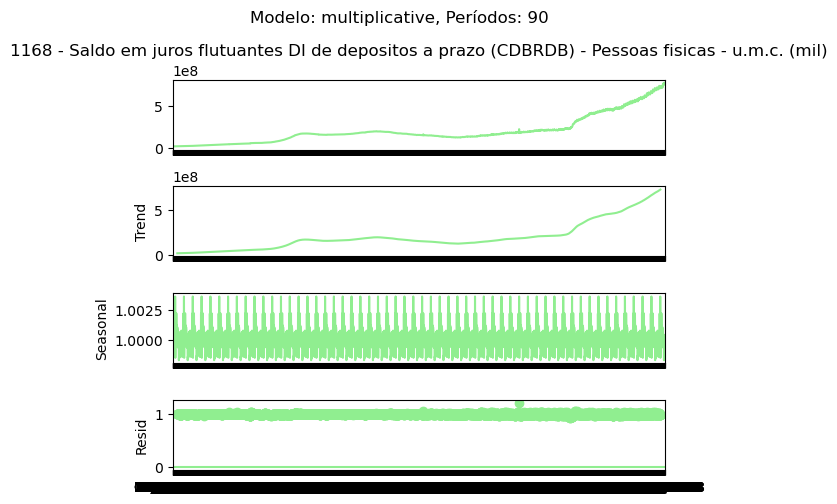

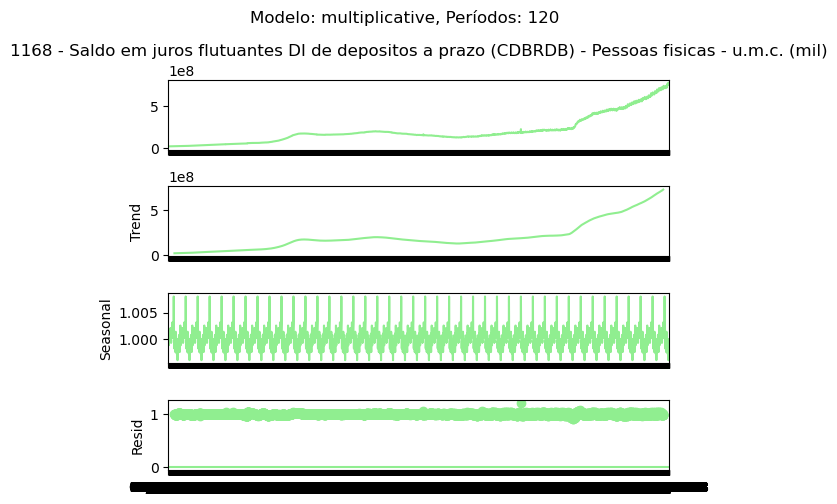

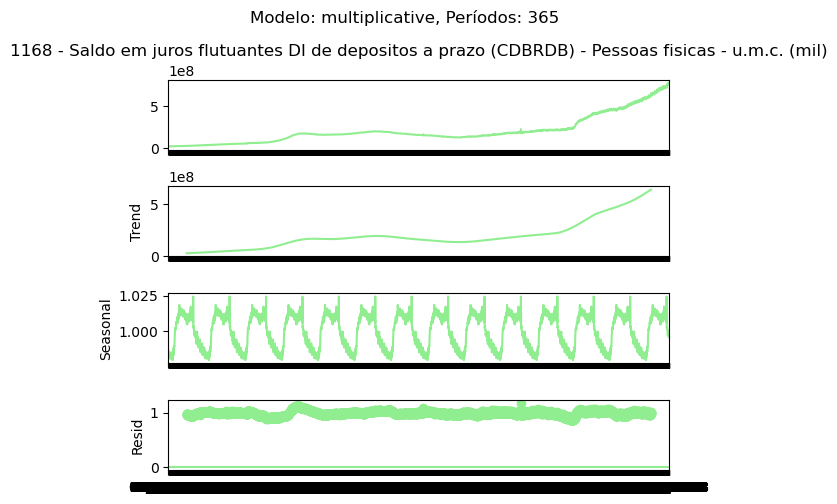

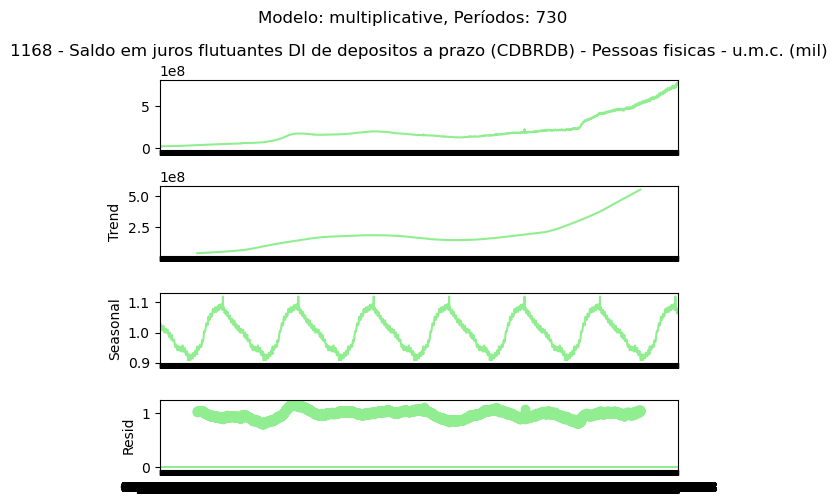

In [6]:
def plot_seasonal_decompose(df):
    periods = [30, 60, 90, 120, 365, 730]
    models = ['additive', 'multiplicative']
    
    for model in models:
        for period in periods:
            result = seasonal_decompose(df.iloc[:, 0], model=model, period=period)
            
            fig = result.plot()
            plt.suptitle(f'Modelo: {model}, Períodos: {period}', y=1.04)

            for ax in fig.get_axes():
                for line in ax.get_lines():
                    line.set_color('lightgreen')
            plt.show()
            
            
plot_seasonal_decompose(df)

### Teste ADF

 No código abaixo iremos apenas verificar se o valor do teste ADF e o p-valor da nossa série conseguem confirmar ela como estacionária ou não. Acredito que por causa da sazonalidade e tendência crescente que observamos anteriormente, esse resultado dê negativo e que provavelmente precisaríamos processar os dados em uma etapa a mais quando tentarmos aplicar os modelos de séries temporais.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Supondo que o DataFrame se chame df e a coluna seja a especificada
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Aplicando o teste ADF na série temporal
result = adfuller(df[saldo_coluna])

# Extraindo resultados
adf = result[0] 
p_valor = result[1]
valores_criticos = result[4]

# Exibindo os resultados
print(f"Valor ADF: {adf}")
print(f"p-valor: {p_valor}")

if p_valor < 0.05:
    print("O p-valor é menor que 0.05, logo, rejeitamos a hipótese nula. A série é estacionária.")
else:
    print("O p-valor é maior que 0.05, logo, não rejeitamos a hipótese nula. A série não é estacionária.")

# Comparando com os valores críticos
for key, valor_critico in valores_criticos.items():
    if adf < valor_critico:
        print(f"O valor ADF é menor do que o valor crítico de {key}: {valor_critico}. A série é estacionária ao nível de significância de {key}.")
    else:
        print(f"O valor ADF é maior do que o valor crítico de {key}: {valor_critico}. A série não é estacionária ao nível de significância de {key}.")


Valor ADF: 4.396895094061529
p-valor: 1.0
O p-valor é maior que 0.05, logo, não rejeitamos a hipótese nula. A série não é estacionária.
O valor ADF é maior do que o valor crítico de 1%: -3.4316614186797896. A série não é estacionária ao nível de significância de 1%.
O valor ADF é maior do que o valor crítico de 5%: -2.8621195049660733. A série não é estacionária ao nível de significância de 5%.
O valor ADF é maior do que o valor crítico de 10%: -2.567078471244475. A série não é estacionária ao nível de significância de 10%.


Como visto nos resultados acima, nosso teste ADF foi "reprovado" em todos os níveis de significância relevantes possíveis, então nossa série precisará passar por um processamento adicional quando aplicarmos os modelos ARIMA e SARIMA.

Para verificar isso, tentaremos utilizar o instrumento de diferenciação de primeiro grau (subtrair a observação atual (t) pela observação imediatamente do passado (t-1). 

Verificação após a diferenciação para ver se consegue se adequar para os comportamentos de estacionariedade.

In [7]:
from statsmodels.tsa.stattools import adfuller

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Calculando a diferença da série temporal e removendo valores NaN
serie_diferenciada = df[saldo_coluna].diff().dropna()

# Aplicando o teste ADF na série temporal diferenciada
result = adfuller(serie_diferenciada)

# Extraindo os resultados
adf = result[0] 
p_valor = result[1]
valores_criticos = result[4]

# Exibindo os resultados
print(f"Valor ADF: {adf}")
print(f"p-valor: {p_valor}")

# Verificando se a série diferenciada é estacionária
if p_valor < 0.05:
    print("O p-valor é menor que 0.05, logo, rejeitamos a hipótese nula. A série diferenciada é estacionária.")
else:
    print("O p-valor é maior que 0.05, logo, não rejeitamos a hipótese nula. A série diferenciada não é estacionária.")

# Comparando com os valores críticos
for key, valor_critico in valores_criticos.items():
    if adf < valor_critico:
        print(f"O valor ADF é menor do que o valor crítico de {key}: {valor_critico}. A série diferenciada é estacionária ao nível de significância de {key}.")
    else:
        print(f"O valor ADF é maior do que o valor crítico de {key}: {valor_critico}. A série diferenciada não é estacionária ao nível de significância de {key}.")


Valor ADF: -4.300269484436675
p-valor: 0.00044373527009224393
O p-valor é menor que 0.05, logo, rejeitamos a hipótese nula. A série diferenciada é estacionária.
O valor ADF é menor do que o valor crítico de 1%: -3.4316614186797896. A série diferenciada é estacionária ao nível de significância de 1%.
O valor ADF é menor do que o valor crítico de 5%: -2.8621195049660733. A série diferenciada é estacionária ao nível de significância de 5%.
O valor ADF é menor do que o valor crítico de 10%: -2.567078471244475. A série diferenciada é estacionária ao nível de significância de 10%.


### Suavização Exponencial e Holt-Winters
**** **ta bugada** ****

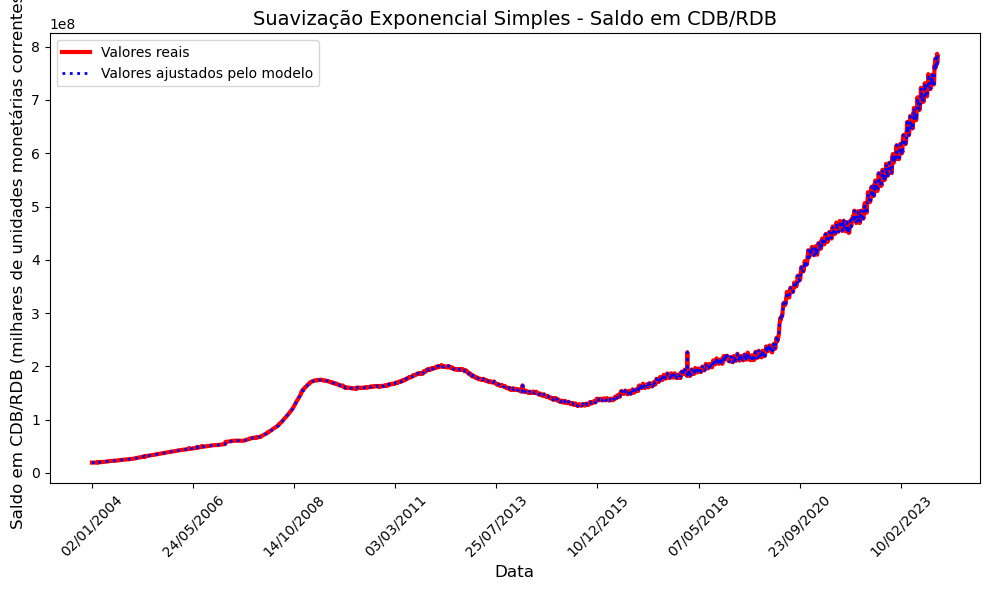

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando o modelo de Suavização Exponencial Simples
model = SimpleExpSmoothing(df[saldo_coluna])

# Ajustando o modelo aos dados
model_fit = model.fit()

# Adicionando os valores ajustados pelo modelo ao DataFrame
df['HWES'] = model_fit.fittedvalues

# Plotando os valores reais e os valores ajustados pelo modelo
plt.figure(figsize=(10, 6))  # Tamanho do gráfico
plt.plot(df[saldo_coluna], label='Valores reais', color='red', linewidth=3)  # Linha real mais espessa
plt.plot(df['HWES'], label='Valores ajustados pelo modelo', color='blue', linestyle=':', linewidth=2)  # Linha azul pontilhada

# Ajustando o título e os eixos
plt.title('Suavização Exponencial Simples - Saldo em CDB/RDB', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)', fontsize=12)

# Formatando o eixo x (datas) para melhorar a legibilidade
plt.xticks(rotation=45)  # Rotaciona as datas
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Exibe no máximo 10 datas no eixo x

# Exibindo a legenda
plt.legend()

# Mostrando o gráfico
plt.tight_layout()  # Ajusta automaticamente para que os rótulos não fiquem sobrepostos
plt.show()


O método de Holt-Winters (HWS) usa suavização exponencial e considera três componentes de uma série temporal: nível, tendência e sazonalidade, e os utiliza para fazer previsões para períodos futuros baseados nos valores passados da mesma.

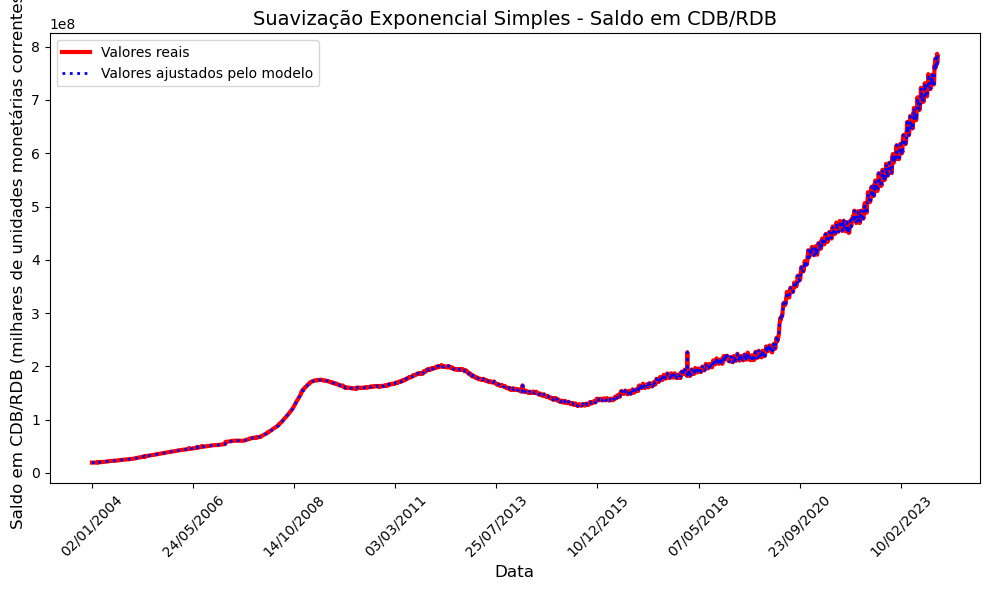

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando o modelo de Suavização Exponencial Simples
model = SimpleExpSmoothing(df[saldo_coluna])

# Ajustando o modelo aos dados
model_fit = model.fit()

# Adicionando os valores ajustados pelo modelo ao DataFrame
df['HWES'] = model_fit.fittedvalues

# Plotando os valores reais e os valores ajustados pelo modelo
plt.figure(figsize=(10, 6))  # Tamanho do gráfico
plt.plot(df[saldo_coluna], label='Valores reais', color='red', linewidth=3)  # Linha real mais espessa
plt.plot(df['HWES'], label='Valores ajustados pelo modelo', color='blue', linestyle=':', linewidth=2)  # Linha azul pontilhada

# Ajustando o título e os eixos
plt.title('Suavização Exponencial Simples - Saldo em CDB/RDB', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)', fontsize=12)

# Formatando o eixo x (datas) para melhorar a legibilidade
plt.xticks(rotation=45)  # Rotaciona as datas
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Exibe no máximo 10 datas no eixo x

# Exibindo a legenda
plt.legend()

# Mostrando o gráfico
plt.tight_layout()  # Ajusta automaticamente para que os rótulos não fiquem sobrepostos
plt.show()


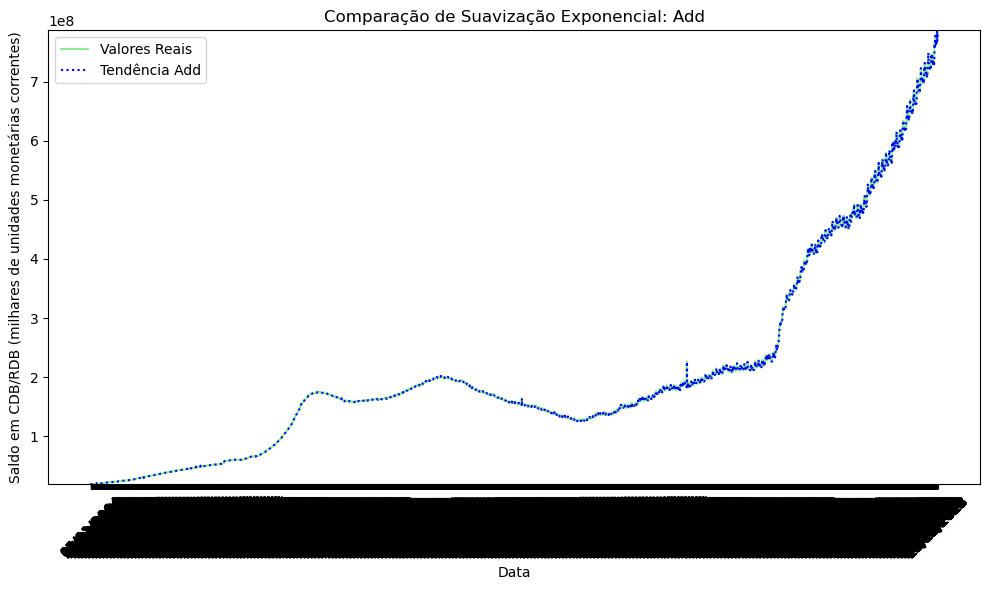

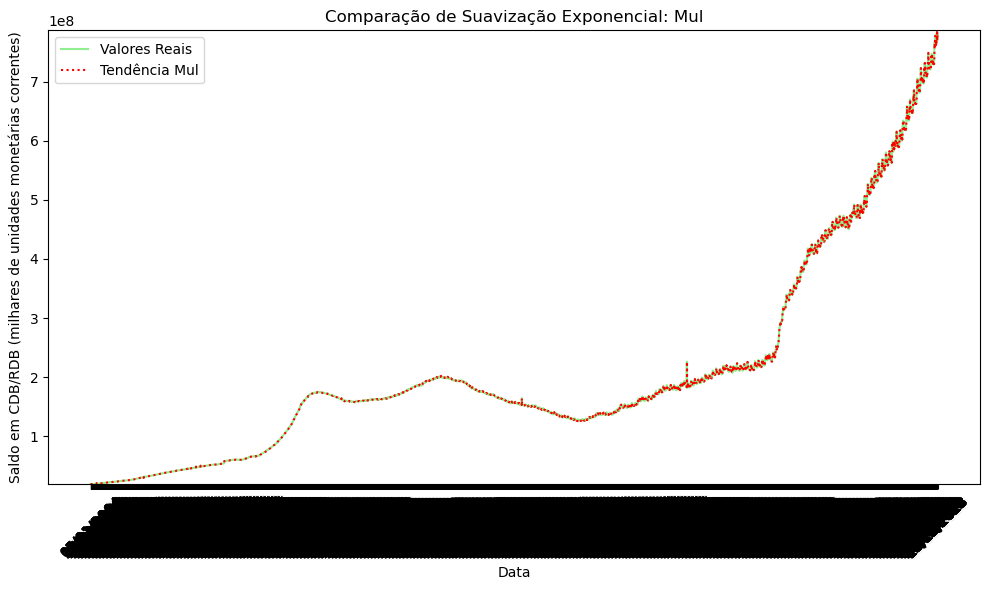

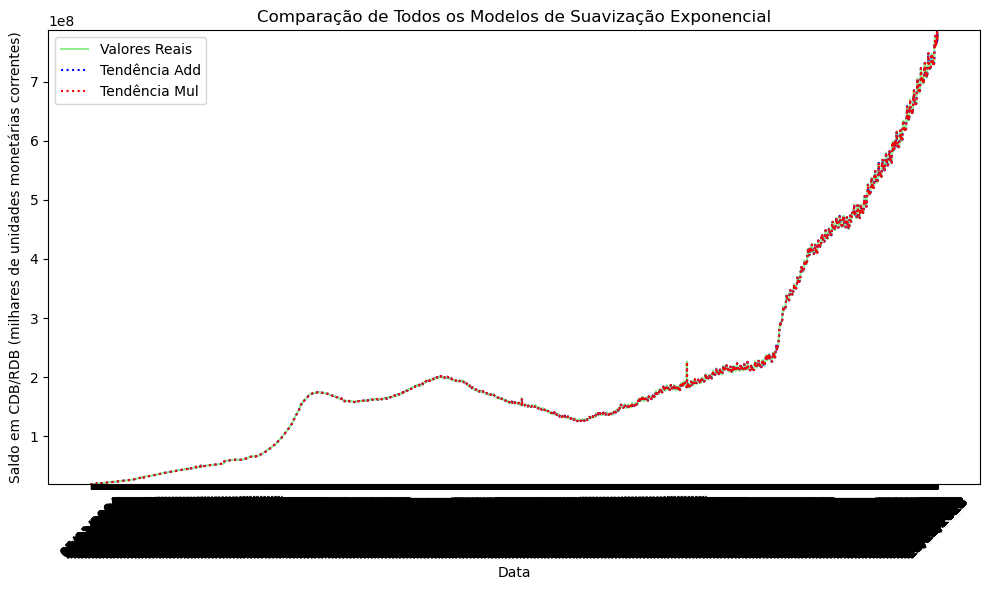

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing

def plot_exponential_smoothing(df):
    # Nome da coluna no DataFrame
    saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'
    
    # Tendências a serem testadas
    trends = ['add', 'mul']
    
    fitted_values = {}
    
    # Ajustando o modelo para cada tendência
    for trend in trends:
        model_name = f'{trend}'
        fitted_values[model_name] = ExponentialSmoothing(
            df[saldo_coluna], trend=trend
        ).fit().fittedvalues

    # Plotando cada modelo de suavização exponencial
    for model_name, values in fitted_values.items():
        plt.figure(figsize=(10, 6))
        plt.plot(df[saldo_coluna], label='Valores Reais', color='lightgreen')
        plt.plot(values, label=f'Tendência {model_name.capitalize()}', 
                 color='blue' if model_name == 'add' else 'red', linestyle=':')
        plt.title(f'Comparação de Suavização Exponencial: {model_name.capitalize()}')
        plt.xlabel('Data')
        plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)')
        plt.ylim(bottom=df[saldo_coluna].min(), top=df[saldo_coluna].max())  # Ajuste dinâmico dos limites do eixo y
        plt.xticks(rotation=45)  # Rotaciona as datas
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plotando todos os modelos em um único gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df[saldo_coluna], label='Valores Reais', color='lightgreen')
    
    for model_name, values in fitted_values.items():
        plt.plot(values, label=f'Tendência {model_name.capitalize()}', 
                 color='blue' if model_name == 'add' else 'red', linestyle=':')

    plt.title('Comparação de Todos os Modelos de Suavização Exponencial')
    plt.xlabel('Data')
    plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)')
    plt.ylim(bottom=df[saldo_coluna].min(), top=df[saldo_coluna].max())  # Ajuste dinâmico dos limites do eixo y
    plt.xticks(rotation=45)  # Rotaciona as datas
    plt.legend()
    plt.tight_layout()
    plt.show()

# Chamada da função com o seu DataFrame
plot_exponential_smoothing(df)


### Modelos ARMA, ARIMA e Variações

Serie Temporal Diferenciada

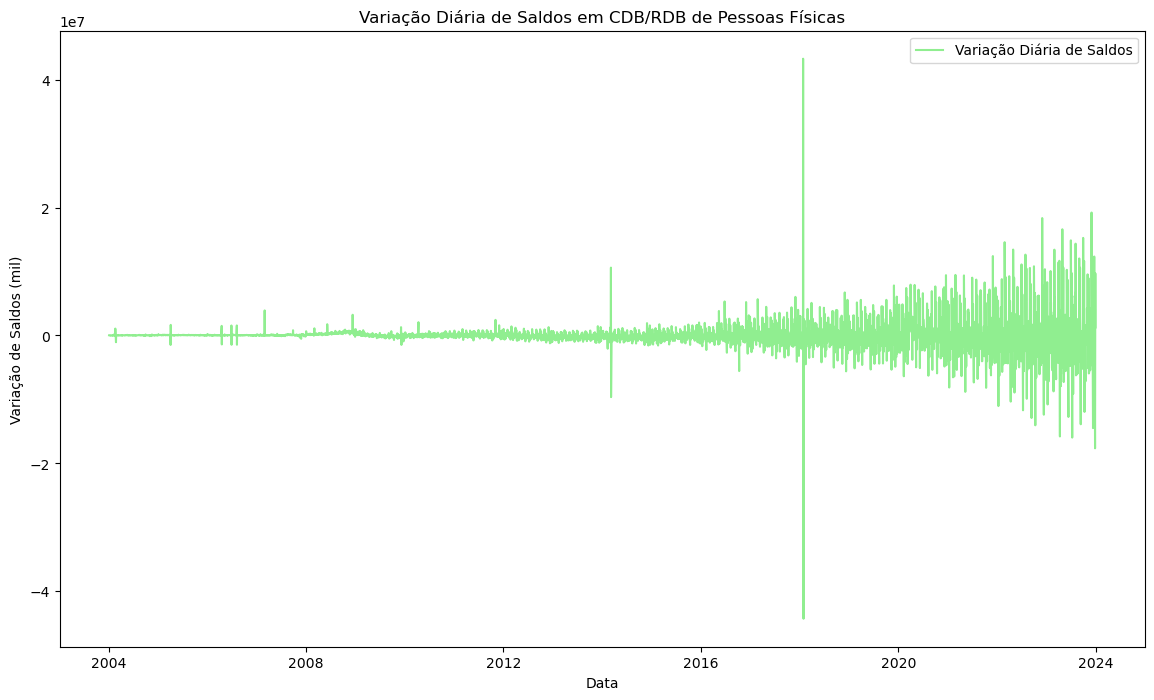

In [71]:
import matplotlib.pyplot as plt

# Calculando a diferença diária
df_diff = df.diff()

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Plotando a variação diária
plt.figure(figsize=(14, 8))
plt.plot(df_diff[saldo_coluna], label='Variação Diária de Saldos', color='lightgreen')
plt.xlabel('Data')
plt.ylabel('Variação de Saldos (mil)')
plt.title('Variação Diária de Saldos em CDB/RDB de Pessoas Físicas')
plt.legend()
plt.show()


### FAC e FACP na série original

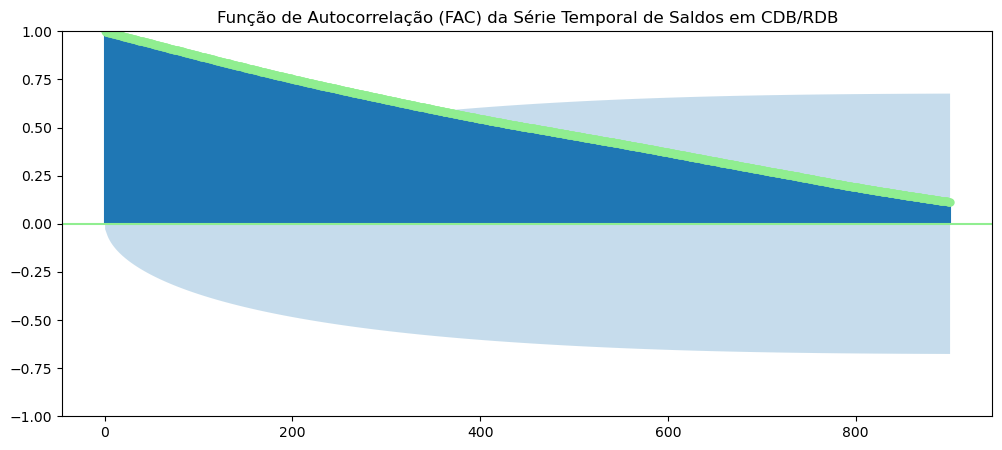

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 5))

# Plotando a Função de Autocorrelação (FAC) com 900 defasagens
plot_acf(df[saldo_coluna], lags=900, ax=ax, alpha=0.05, color='lightgreen')  # alpha = 0.05 para nível de confiança de 95%
ax.set_title("Função de Autocorrelação (FAC) da Série Temporal de Saldos em CDB/RDB")
plt.show()


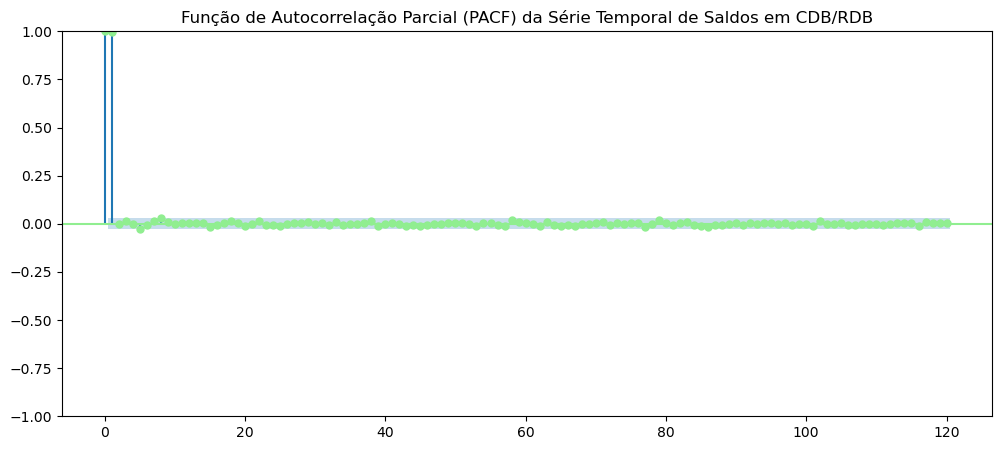

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 5))

# Plotando a Função de Autocorrelação Parcial (PACF) com 120 defasagens
plot_pacf(df[saldo_coluna], lags=120, ax=ax, alpha=0.05, color='lightgreen')  # alpha = 0.05 para nível de confiança de 95%
ax.set_title("Função de Autocorrelação Parcial (PACF) da Série Temporal de Saldos em CDB/RDB")
plt.show()


### FAC e FACP na série diferenciada

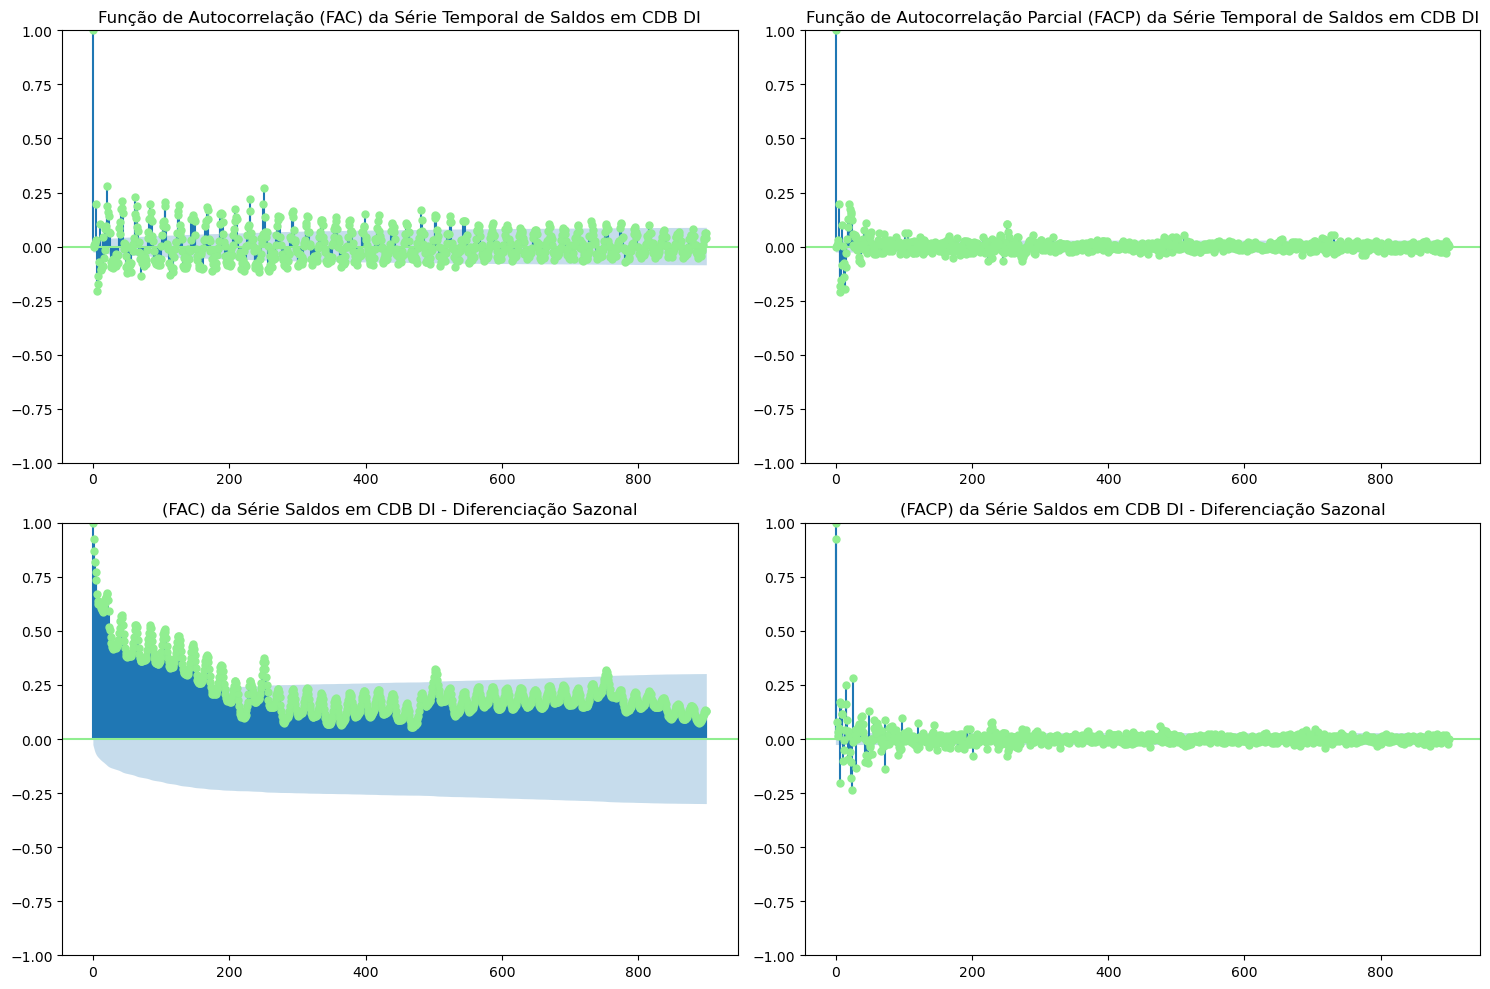

In [101]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Nome da coluna no DataFrame
#saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando as diferenciações
#df['diferenca'] = df[saldo_coluna].diff().dropna()
#df['diferenca_sazonal'] = df[saldo_coluna].diff(24).dropna()  # Exemplo com periodicidade 24

# Criando figuras e eixos para FAC e FACP
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico da FAC da série diferenciada
plot_acf(df['diferenca'].dropna(), lags=900, ax=axs[0, 0], alpha=0.05, color='lightgreen')
axs[0, 0].set_title("Função de Autocorrelação (FAC) da Série Temporal de Saldos em CDB DI")

# Gráfico da FACP da série diferenciada
plot_pacf(df['diferenca'].dropna(), lags=900, ax=axs[0, 1], alpha=0.05, color='lightgreen')
axs[0, 1].set_title("Função de Autocorrelação Parcial (FACP) da Série Temporal de Saldos em CDB DI")

# Gráfico da FAC da série diferenciada sazonal
plot_acf(df['diferenca_sazonal'].dropna(), lags=900, ax=axs[1, 0], alpha=0.05, color='lightgreen')
axs[1, 0].set_title("(FAC) da Série Saldos em CDB DI - Diferenciação Sazonal")

# Gráfico da FACP da série diferenciada sazonal
plot_pacf(df['diferenca_sazonal'].dropna(), lags=900, ax=axs[1, 1], alpha=0.05, color='lightgreen')
axs[1, 1].set_title("(FACP) da Série Saldos em CDB DI - Diferenciação Sazonal")

# Ajustar layout e mostrar os gráficos
plt.tight_layout()
plt.show()


#### lixo

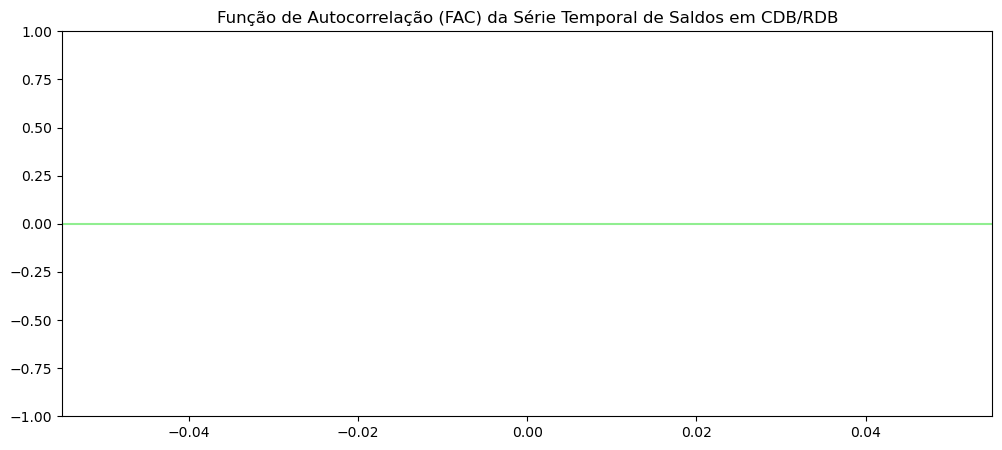

In [70]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 5))

# Plotando a Função de Autocorrelação (FAC) com 900 defasagens
plot_acf(df_diff[saldo_coluna], lags=900, ax=ax, alpha=0.05, color='lightgreen')  # alpha = 0.05 para nível de confiança de 95%
ax.set_title("Função de Autocorrelação (FAC) da Série Temporal de Saldos em CDB/RDB")
plt.show()


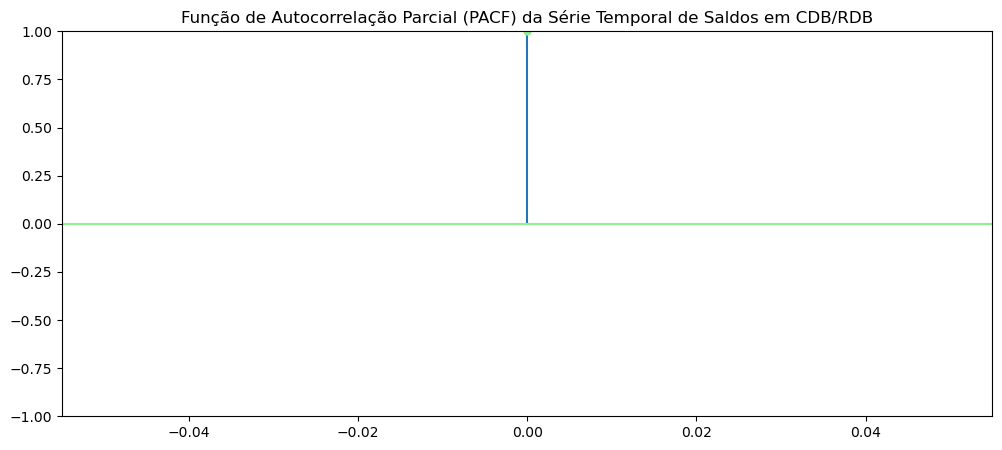

In [22]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 5))

# Plotando a Função de Autocorrelação Parcial (PACF) com 120 defasagens
plot_pacf(df_diff[saldo_coluna], lags=120, ax=ax, alpha=0.05, color='lightgreen')  # alpha = 0.05 para nível de confiança de 95%
ax.set_title("Função de Autocorrelação Parcial (PACF) da Série Temporal de Saldos em CDB/RDB")
plt.show()


### Auto ARIMA

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Definindo a série temporal
data = df[saldo_coluna]

# Modelo Auto ARIMA
auto_arima_model = auto_arima(data, seasonal=False, trace=True,
                               error_action='ignore', suppress_warnings=True, stepwise=True)

# Resumo do modelo
print(auto_arima_model.summary())

# Ajuste do modelo ARIMA
model_fit = auto_arima_model.fit(data)

# Previsões
forecast = model_fit.predict(n_periods=30)




Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=164136.425, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=162677.468, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=164134.426, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=162058.961, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=161699.536, Time=0.41 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=161063.285, Time=0.59 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=161034.263, Time=0.81 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=161035.922, Time=2.87 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=161038.315, Time=1.84 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=161032.259, Time=0.70 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=161061.281, Time=0.48 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=161033.918, Time=2.49 sec
 ARIMA(4,2,1)(0,0,0

*** Ajuste do gráfico ***

In [43]:
# Carregar a série temporal
df = pd.read_csv('Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas.csv', encoding='ISO-8859-1', sep=';', parse_dates=['Data'], index_col='Data')

# Converte a coluna removendo pontos e trocando a vírgula por ponto
df['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'] = (
    df['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)']
    .str.replace('.', '', regex=False)  # Remove os pontos
    .str.replace(',', '.', regex=False)  # Troca a vírgula por ponto
    .astype(float)                       # Converte para float
)


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5020 entries, 02/01/2004 to 29/12/2023
Data columns (total 1 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)  5020 non-null   float64
dtypes: float64(1)
memory usage: 78.4+ KB


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=164136.425, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=162677.468, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=164134.426, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=162058.961, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=161699.536, Time=0.42 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=161063.285, Time=0.60 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=161034.263, Time=0.82 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=161035.922, Time=2.81 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=161038.315, Time=2.25 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=161032.259, Time=0.98 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=161061.281, Time=0.64 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=161033.918, Time=3.24 sec
 ARIMA(4,2,1)(0,0,0

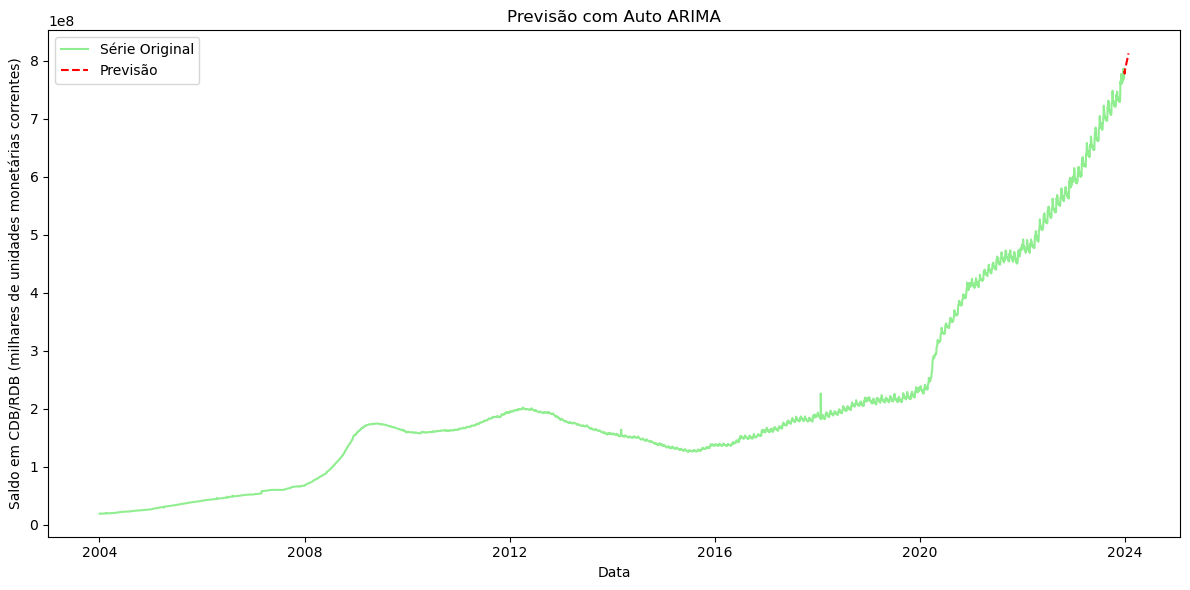

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Converter o índice do DataFrame para o tipo datetime
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Definindo a série temporal
data = df[saldo_coluna]

# Modelo Auto ARIMA
auto_arima_model = auto_arima(data, seasonal=False, trace=True,
                               error_action='ignore', suppress_warnings=True, stepwise=True)

# Resumo do modelo
print(auto_arima_model.summary())

# Ajuste do modelo ARIMA
model_fit = auto_arima_model.fit(data)

# Previsões
forecast = model_fit.predict(n_periods=30)

# Criando um índice de datas para as previsões
forecast_index = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plotando a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(data, label='Série Original', color='lightgreen')
plt.plot(forecast_index, forecast, label='Previsão', color='red', linestyle='--')
plt.title('Previsão com Auto ARIMA')
plt.xlabel('Data')
plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)')
plt.legend()
plt.tight_layout()  # Ajusta o layout
plt.show()


### ARIMA(5,2,0)

In [63]:
# Carregar a série temporal
df = pd.read_csv('Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas.csv', encoding='ISO-8859-1', sep=';', parse_dates=['Data'], index_col='Data')

# Converte a coluna removendo pontos e trocando a vírgula por ponto
df['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'] = (
    df['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)']
    .str.replace('.', '', regex=False)  # Remove os pontos
    .str.replace(',', '.', regex=False)  # Troca a vírgula por ponto
    .astype(float)                       # Converte para float
)


Ajustando o modelo ARIMA: 100%|██████████| 100/100 [00:00<00:00, 122.62it/s]


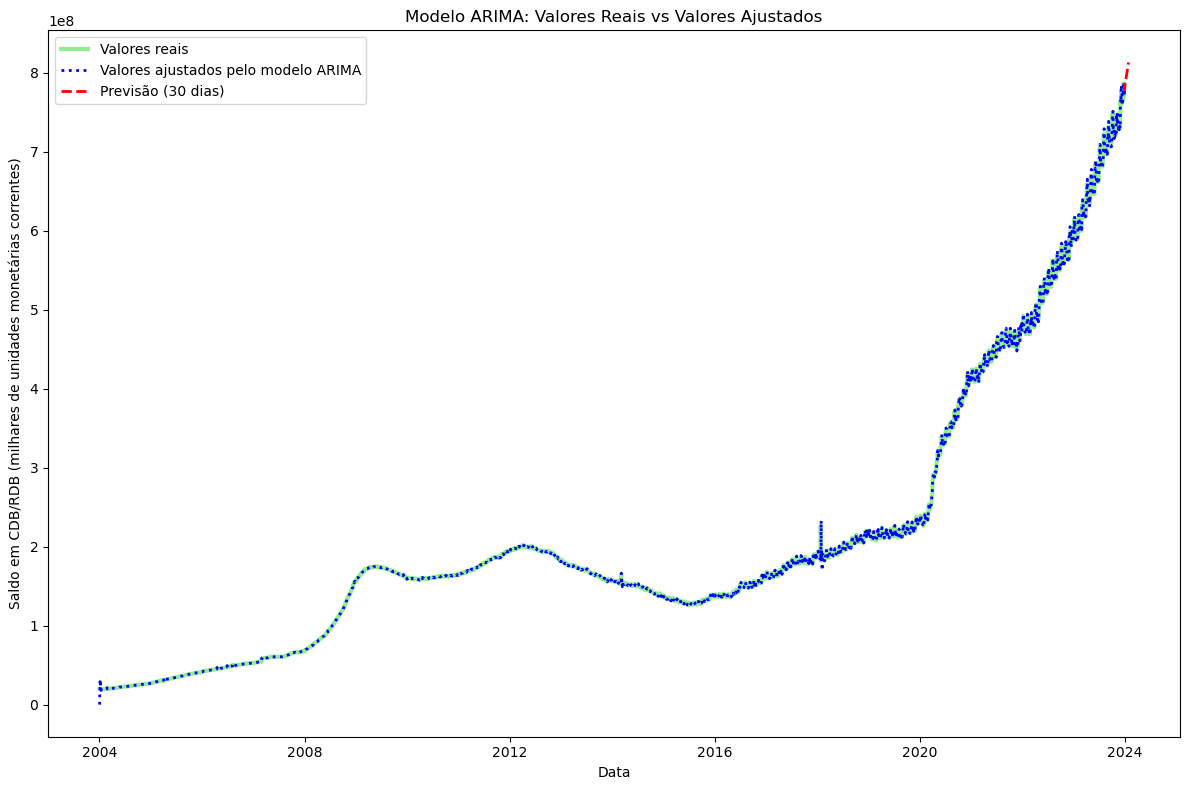

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# Nome da coluna no DataFrame
saldo_coluna = '1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'

# Certificando-se de que o índice do DataFrame seja do tipo datetime
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Ajustando o modelo SARIMAX com os melhores parâmetros do Auto ARIMA
model = SARIMAX(df[saldo_coluna], order=(5, 2, 0))

# Ajustando o modelo e mostrando a barra de progresso
with tqdm(total=100, desc="Ajustando o modelo ARIMA") as pbar:
    model_fit = model.fit(disp=False, maxiter=50, method='powell')
    pbar.update(100)

# Adicionando os valores ajustados pelo modelo ao DataFrame
df['ARIMA'] = model_fit.fittedvalues

# Criando previsões para os próximos 30 dias
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Convertendo as previsões para um DataFrame
forecast_values = forecast.predicted_mean

# Plotando a série original e os valores ajustados pelo modelo ARIMA
plt.figure(figsize=(12, 8))
plt.plot(df[saldo_coluna], label='Valores reais', color='lightgreen', linewidth=3)  # Linha para valores reais
plt.plot(df['ARIMA'], label='Valores ajustados pelo modelo ARIMA', color='blue', linestyle=':', linewidth=2)  # Linha pontilhada para valores ajustados

# Adicionando previsões ao gráfico
plt.plot(forecast_index, forecast_values, label='Previsão (30 dias)', color='red', linestyle='--', linewidth=2)  # Linha de previsão

plt.title('Modelo ARIMA: Valores Reais vs Valores Ajustados')
plt.xlabel('Data')
plt.ylabel('Saldo em CDB/RDB (milhares de unidades monetárias correntes)')
plt.legend()
plt.tight_layout()  # Ajusta o layout
plt.show()


In [68]:
# Criando previsões para os próximos 30 dias
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Convertendo as previsões para um DataFrame
forecast_values = forecast.predicted_mean

# Pegando o saldo previsto para daqui 30 dias
saldo_previsto_30_dias = forecast_values.iloc[-1]

# Printando o valor do saldo previsto para daqui a 30 dias
print(f"Saldo previsto para daqui 30 dias: {saldo_previsto_30_dias:.2f}")


Saldo previsto para daqui 30 dias: 813035309.77
